# cu_inj Reference simulation

In [1]:
# %pylab --no-import-all inline
%config InlineBackend.figure_format = 'retina'

In [2]:
from impact import Impact
from distgen import Generator
import os
from pmd_beamphysics.plot import density_and_slice_plot, slice_plot
NAME = 'impact_cu_inj_v0_300k_particles'
import matplotlib.pyplot as plt

os.environ["LCLS_LATTICE"] ='/sdf/group/ad/beamphysics/lcls-lattice'  #point to the lcls repo here. If you clond your own repo you can pooint to this


## partions to run the impact and genesis simulations. 

partion= 'partition milano'
account= 'ad:beamphysics'


#GFILE = os.path.expandvars('$LCLS_LATTICE/distgen/models/cu_inj/vcc_image/distgen.yaml')
GFILE = os.path.expandvars('$LCLS_LATTICE/distgen/models/cu_inj/v0/distgen.yaml')
# YFILE = os.path.expandvars('$LCLS_LATTICE/impact/models/cu_inj/v0/ImpactT.yaml')
infile = os.path.expandvars('$LCLS_LATTICE/impact/models/cu_inj/v0/ImpactT.in')
IFILE = os.path.expandvars(infile)

In [3]:
%%time

#Generator may require the distgen file to specify species, the example provided doesn't do this so this is a work around. 
# It may be eassier just to manally edit disten.yaml to incldue this. 

GFILE_new_path='./distgen.yaml'
os.system(f' cp {GFILE} {GFILE_new_path}')
with open(GFILE_new_path, 'a') as f:
    f.write('species: electron\n')
G = Generator(GFILE_new_path)
G['n_particle'] = 300_000
G.run()
P0 = G.particles
os.system(f' rm {GFILE_new_path}')

CPU times: user 4.77 s, sys: 500 ms, total: 5.27 s
Wall time: 5.65 s


0

# MPI run 300k particles

For this many particles we will prepare an MPI run

In [4]:
# I = Impact.from_yaml(YFILE)
I = Impact(IFILE, workdir=os.path.expandvars('$SCRATCH'))
# Set initial particles
I.initial_particles = P0
I.workdir=os.path.expandvars('$SCRATCH')
## Switches for MPI
I.numprocs = 60
I.stop = 16.5
I.mpi_run

'mpirun -n {nproc} {command_mpi}'

In [5]:
# Change some things
I.header['Nx'] = 64
I.header['Ny'] = 64
I.header['Nz'] = 64

# Run on S3DF

This will run on SLAC's S3DF. Note that you must have access to a partition (allocation) for instant response.

In [6]:
 # SDF setup 
command_mpi=I.command_mpi
settings = {    
 'mpi_run': 'salloc --' + partion +' --account '+ account + ' -N 1 -n {nproc} mpirun -n {nproc} {command_mpi}'
}
for k, v in settings.items():
    I[k] = v
    
I.workdir = os.path.expandvars('$SCRATCH')
I.configure()
print(I)

================ Impact-T Summary ================    
300000 particles
1 bunch of electrons
total charge: 250.0000000000001 pC
Distribution type: read
Cathode start at z = 0 m
   emission time: 6.515803466731775e-12 s
   image charges neglected after z = 0.02 m
Processor domain: 4 x 15 = 60 CPUs
Space charge grid: 64 x 64 x 64
Maximum time steps: 1000000
Reference Frequency: 2856000000.0 Hz
Initial reference time: -3.249141278122655e-12 s
Simulation starting from the beginning
Impact-T configured in /sdf/scratch/users/j/jmorgan/tmp7xc0qbi8


In [7]:
%%time
I.verbose=True
I.run()

Running Impact-T in /sdf/scratch/users/j/jmorgan/tmp7xc0qbi8
salloc --partition milano --account ad:beamphysics -N 1 -n 60 mpirun -n 60 /sdf/home/j/jmorgan/conda/envs/jconda/bin/ImpactTexe-mpi
writing 300000 particles to /sdf/scratch/users/j/jmorgan/tmp7xc0qbi8/partcl.data
Cathode start with cathode_kinetic_energy_ref = 1.0 eV
Cathode start: Replaced Np with 300000 according to initial particles
Cathode start: Replaced Bkenergy with 1.0 according to initial particles
Cathode start: Replaced Temission with 6.502797870989826e-12 according to initial particles
Cathode start: Replaced Tini with -3.260159390738143e-12 according to initial particles
Setting total charge to 2.500000000000001e-10 C


salloc: Pending job allocation 45383844
salloc: job 45383844 queued and waiting for resources
salloc: job 45383844 has been allocated resources
salloc: Granted job allocation 45383844
salloc: Waiting for resource configuration
salloc: Nodes sdfmilan105 are ready for job


 !-----------------------------------------------------------
 ! IMPACT-T Parallel Beam Dynamics Tracking Code: V2.2
 ! Copyright of The Regents of the University of California
 !-----------------------------------------------------------
 nblem:           28          28
 pass setting up lattice...
 check randomness:            4  0.26162985749302459     
 check randomness:            6  0.51416758829988740     
 check randomness:            7  0.34132650043064472     
 check randomness:           11  0.53322221244593448     
 check randomness:           12  0.55211380575620983     
 check randomness:           17  0.23317368111879055     
 check randomness:           18  0.35112073448189818     
 check randomness:           20  0.38935044840593969     
 time:    431.28853877500001, elapsed: 445.23960065841675Finished.857, elapsed: 443.7449808120727545215
Loaded fort 27 : Max amplitude information
Loaded fort 25 : RMS Y information
Loaded fort 28 : Load balance and loss diagnostics
Loa

salloc: Relinquishing job allocation 45383844
salloc: Job allocation 45383844 has been revoked.


Loaded fort 18 : Time and energy
Loaded fort 29 : Cube root of third moments of the beam distribution
Loaded fort 70 : Slice information of the final distribution
Loaded fort 60 : Slice information of the initial distribution
Loading particles
Loaded fort 40 : initial particle distribution at t = 0
Loaded fort 50 : final particle distribution projected to the centroid location of the bunch
Loaded write beam particles YAG02 fort.102
Loaded write beam particles YAG03 fort.103
Loaded write beam particles OTR1 fort.105
Loaded write beam particles OTR2 fort.107
Converting z to t according to cathode_kinetic_energy_ref = 1.0 eV
Converted initial_particles to ParticleGroup
Converted final_particles to ParticleGroup
Converted YAG02 to ParticleGroup
Converted YAG03 to ParticleGroup
Converted OTR1 to ParticleGroup
Converted OTR2 to ParticleGroup
CPU times: user 13.3 s, sys: 1.18 s, total: 14.5 s
Wall time: 7min 33s


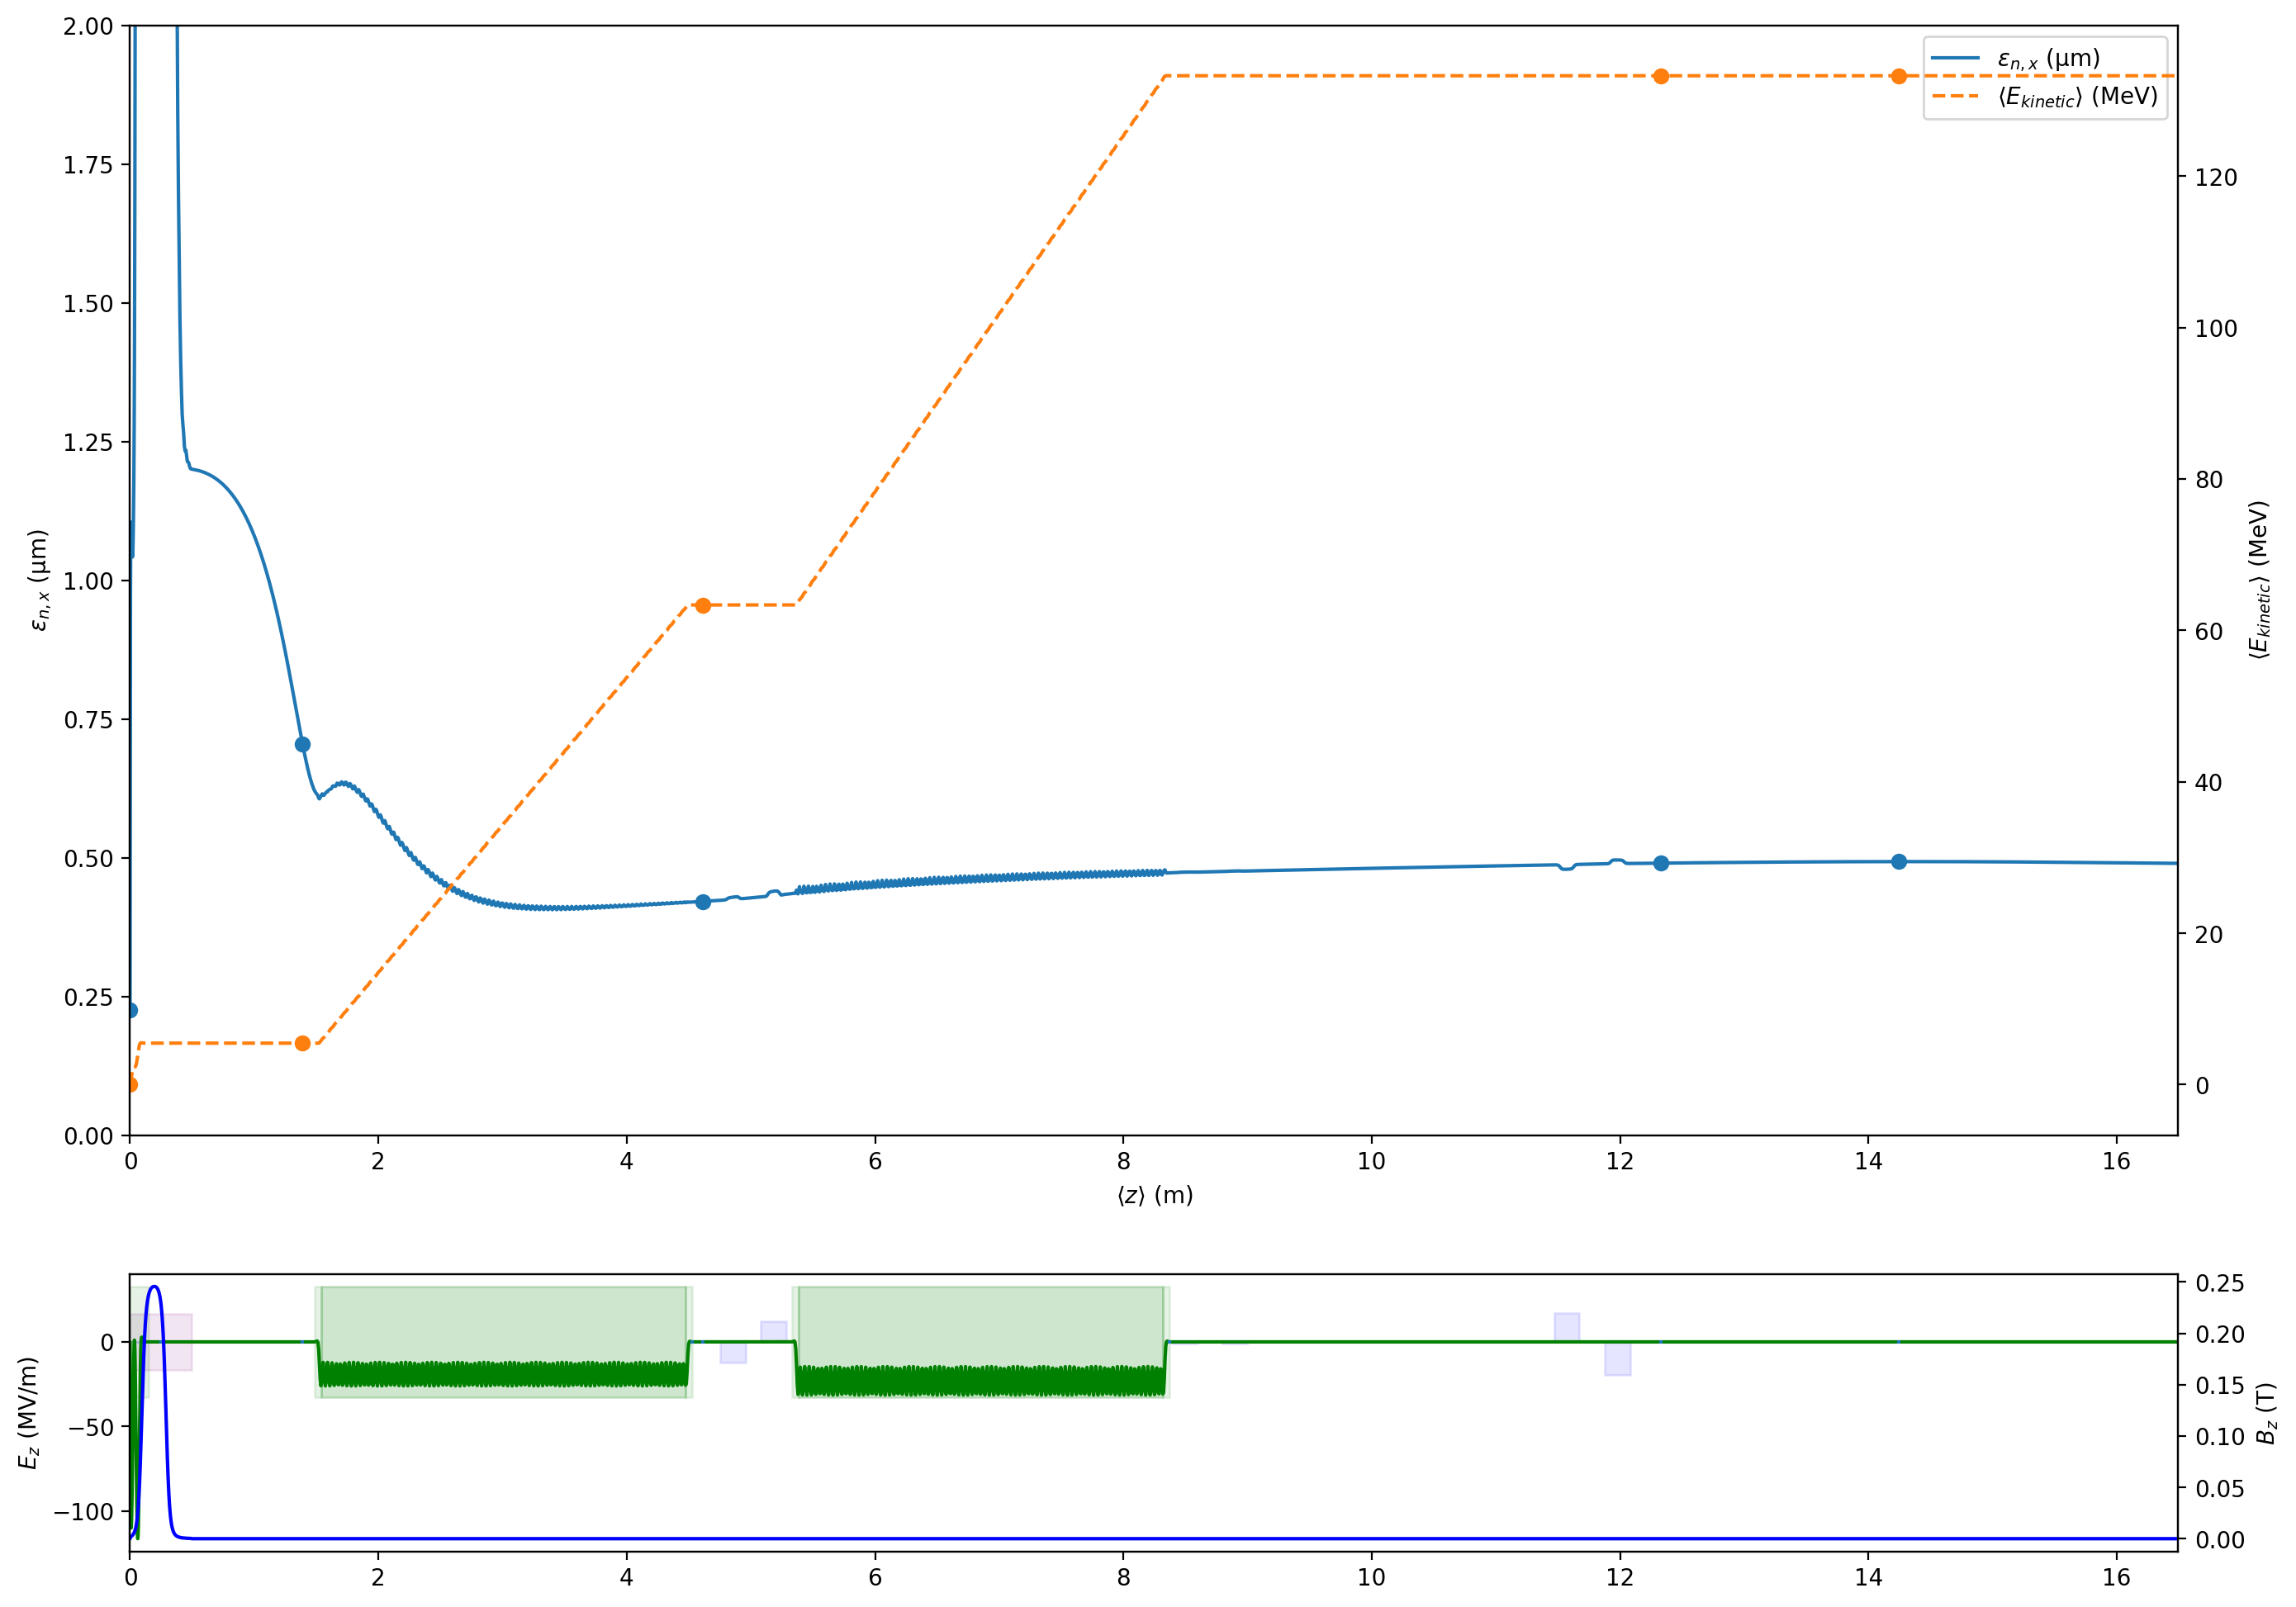

In [8]:
I.plot('norm_emit_x', y2='mean_kinetic_energy', ylim=(0, 2e-6), figsize=(16,12), include_labels=False)

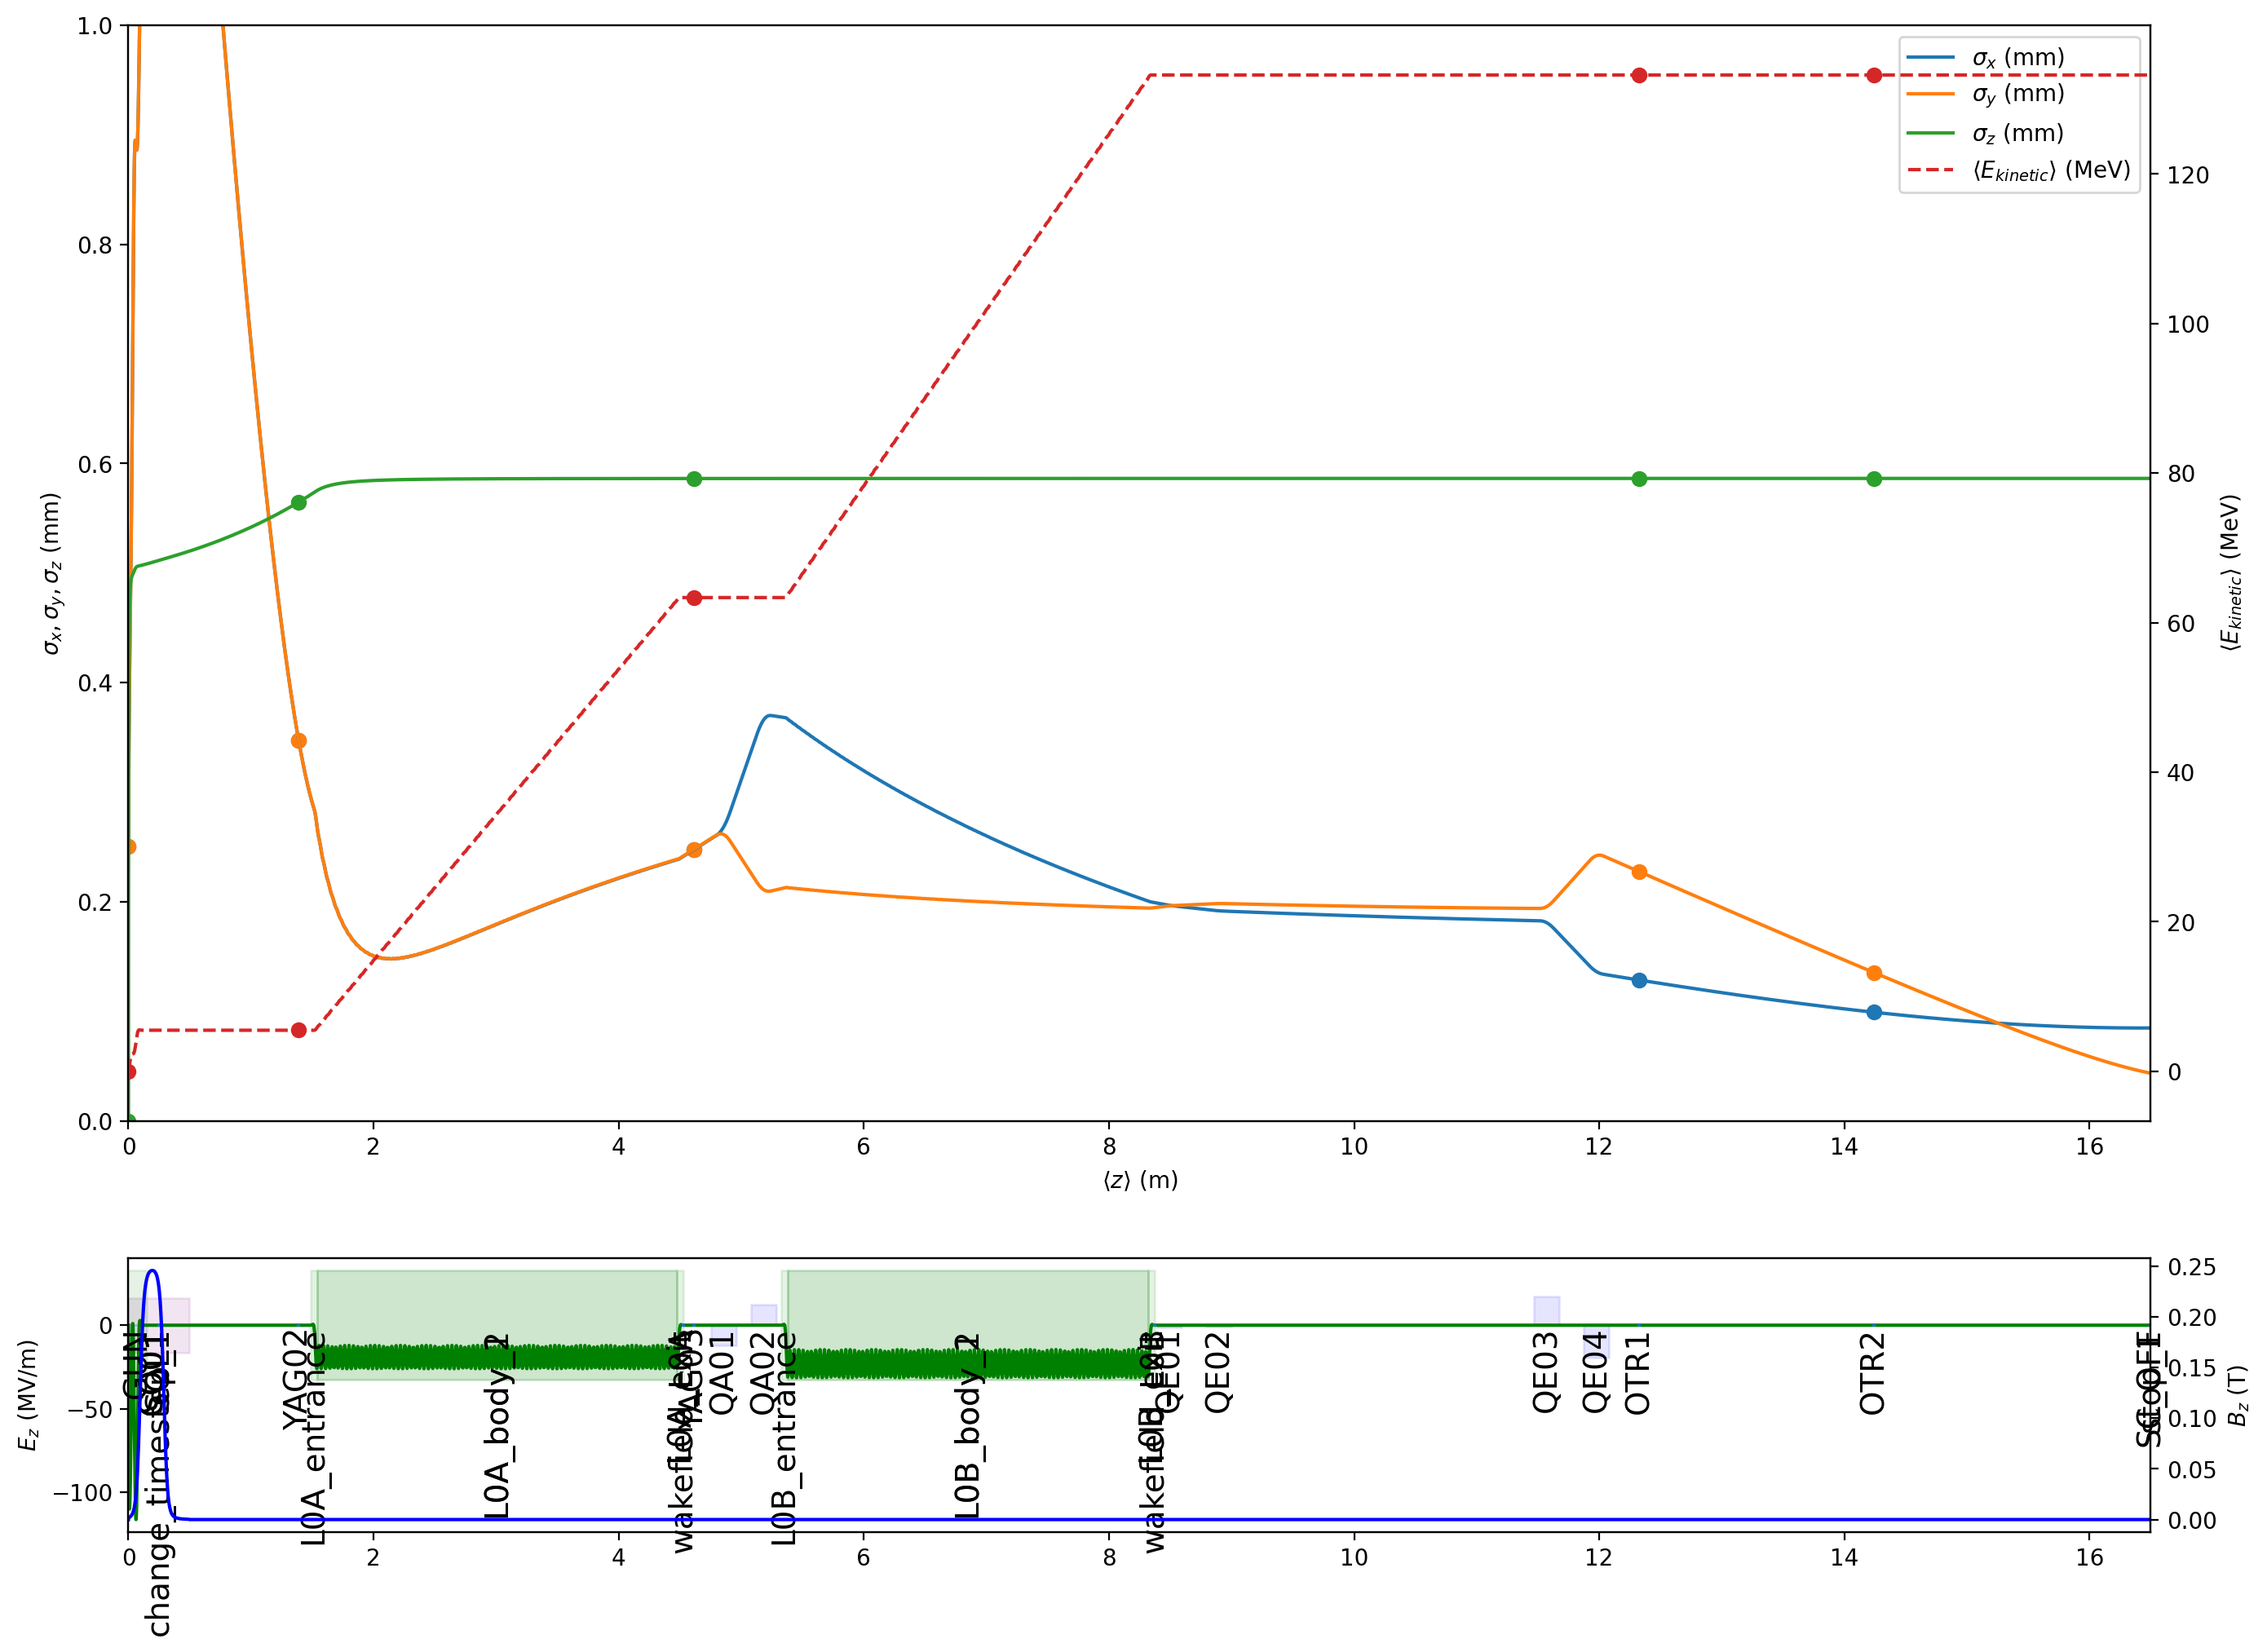

In [9]:
I.plot(['sigma_x', 'sigma_y', 'sigma_z'], y2='mean_kinetic_energy',  ylim=(0, 0.001), xlim=(0, 16.5), figsize=(16, 12), include_labels=True)

In [10]:
I.particles.keys()

dict_keys(['initial_particles', 'final_particles', 'YAG02', 'YAG03', 'OTR1', 'OTR2'])

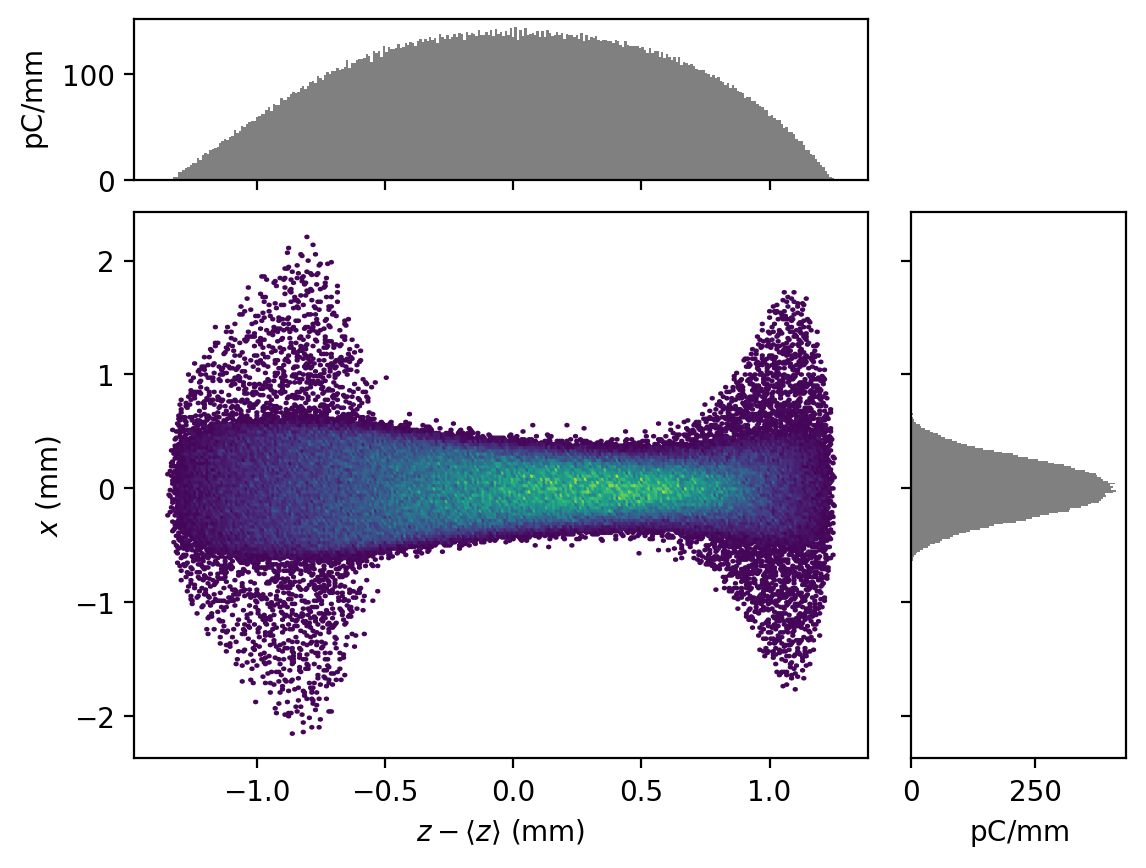

In [11]:
P1 = I.particles['YAG03']

P1.plot('delta_z', 'x')

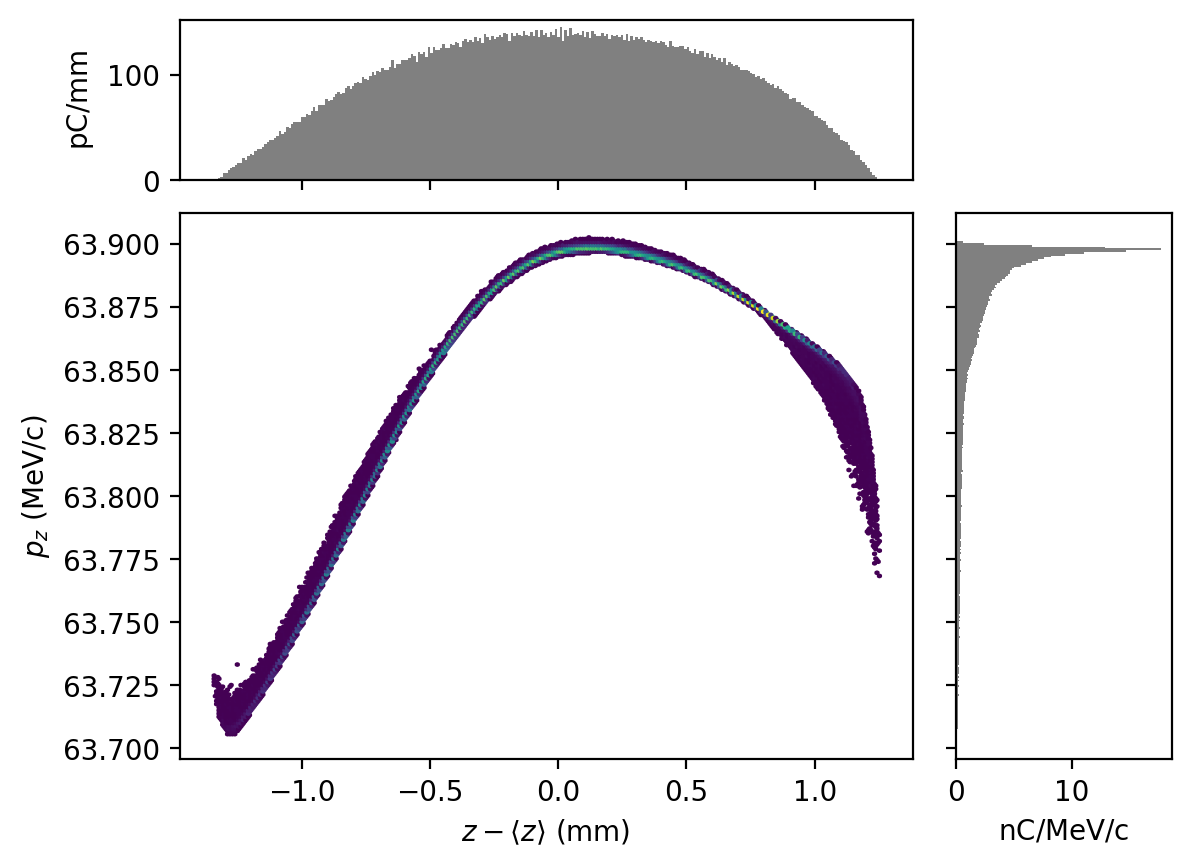

In [12]:
P1.plot('delta_z', 'pz')

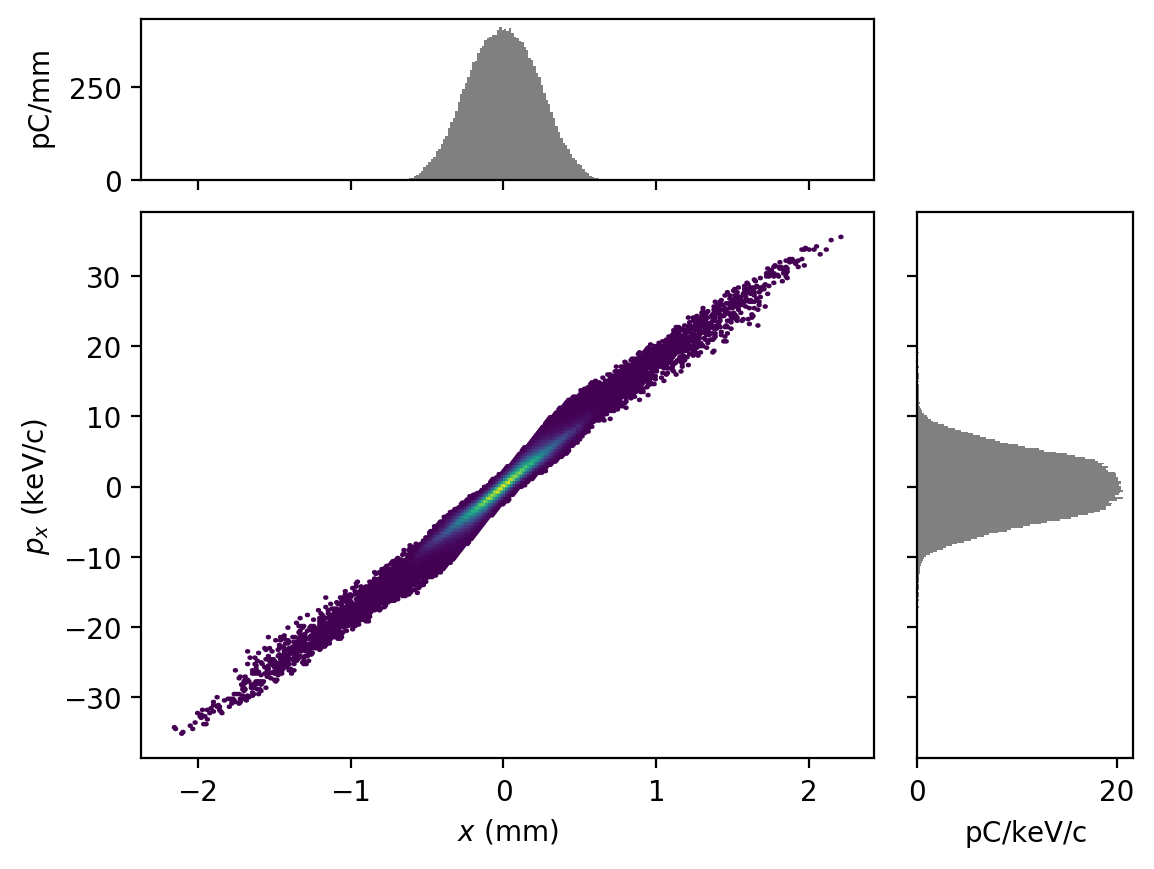

In [13]:
P1.plot('x', 'px')

In [14]:
# 95% Twiss and Emittance
P1.twiss('xy', 0.95)

{'alpha_x': -5.244194252170267,
 'beta_x': 18.538696686225983,
 'gamma_x': 1.5374097670885343,
 'emit_x': 2.5242414008081823e-09,
 'eta_x': -0.00024716658055970144,
 'etap_x': -6.619370137576168e-05,
 'norm_emit_x': 3.154722390836377e-07,
 'alpha_y': -5.246340209429065,
 'beta_y': 18.53553033394724,
 'gamma_y': 1.5388869419523026,
 'emit_y': 2.5328500198559313e-09,
 'eta_y': 0.00012299756007116928,
 'etap_y': 3.7083562142137375e-05,
 'norm_emit_y': 3.16548163326683e-07}

In [15]:
# Write the particles to a file 
folder_path='./store_particles/'
if not os.path.exists(folder_path):
    os.makedirs(folder_path)
PFILE0 = folder_path + 'impact_inj_output.h5'
I.particles['YAG03'].write(PFILE0)

# Inject IMPACT output into Tao/PyTao

In [16]:
from pytao import Tao
from pmd_beamphysics import ParticleGroup

## Parameters

In [17]:
TRACK_START ="YAG03" # Where to start particle tracking (injection element)
TRACK_END = "ENDCLTH_0"#"WSDL31" #"HXRCB1END" #"BC1CEND" # Where to end particle tracking
# Get particles from Lume-Impact sc_inj model, e.g.: 
# I.particles['final_particles'].write('impact_particles_at_14m.h5')

PFILE0 = folder_path + '/impact_inj_output.h5'
# File to write
PFILE = f'bmad_particles_at_{TRACK_START}.h5' 

# Twiss Match parameters (optional) 
twiss_match = True


## Initialize Tao and get reference time

### Running BMAD Simulations with Graphical Output on S3DF Jupyter Notebook

To run BMAD simulations with graphical output on S3DF Jupyter Notebook, follow these steps:

1. **Find the Hostname:**
   - Run the command `hostname` to find out the hostname of the machine where the Jupyter is running.
2. **Establish SSH Connection with X11 Forwarding:**
   - From your local machine, use SSH with X11 forwarding enabled:
     ```bash
     ssh -Y <your-username>@<remote-hostname>
     ```
     For example:
     ```bash
     ssh -Y zihanzhu@s3dflogin
     ```
   - Then, SSH to the specific iana node:
     ```bash
     ssh -Y zihanzhu@sdfiana008
     ```
   - Retrieve the DISPLAY variable using:
     ```bash
     echo $DISPLAY
     ```
3. **Set DISPLAY Environment Variable in Notebook:**
   - Back to Jupyter, set the DISPLAY environment variable in the notebook:
     ```bash
     %env DISPLAY=<DISPLAY variable>
     ```
Now, the graphical interface should appear when you run BMAD with Tao/PyTao. Special thanks to Michael Enrlichman for guidance.



In [18]:
#%env DISPLAY=:44.0  #may need to uncomment this 

In [19]:
tao = Tao('-lat $LCLS_LATTICE/bmad/models/cu_hxr/cu_hxr.lat.bmad')

In [20]:
tao = Tao(f'-init $LCLS_LATTICE/bmad/models/cu_hxr/tao.init -slice BEGINNING:{TRACK_END}')
#tao = Tao(f'-init $LCLS_LATTICE/bmad/models/cu_hxr/tao.init -slice {TRACK_START}:{TRACK_END}')
tao.cmd('place floor sigmaxy')


[]

In [21]:
t_ref = tao.evaluate(f'ele::{TRACK_START}[ref_time]')[0]

t_ref

1.5413714264595368e-08

# Prepare particles

In [22]:
P = ParticleGroup(PFILE0)

# Change to s-coordinates (different times t, constant z)
P.drift_to_z() # drift to P['mean_z']

# Zero out the mean time
P.t += t_ref -P['mean_t']



if twiss_match:
   P.twiss_match(plane='y',beta=tao.lat_list("YAG03",'ele.a.beta'),alpha=tao.lat_list("YAG03",'ele.a.alpha'),inplace=True) 
   P.twiss_match(plane='x',beta=tao.lat_list("YAG03",'ele.b.beta'),alpha=tao.lat_list("YAG03",'ele.b.alpha'),inplace=True)

# Write the file that Tao will read
P.write(PFILE)



# Check particles

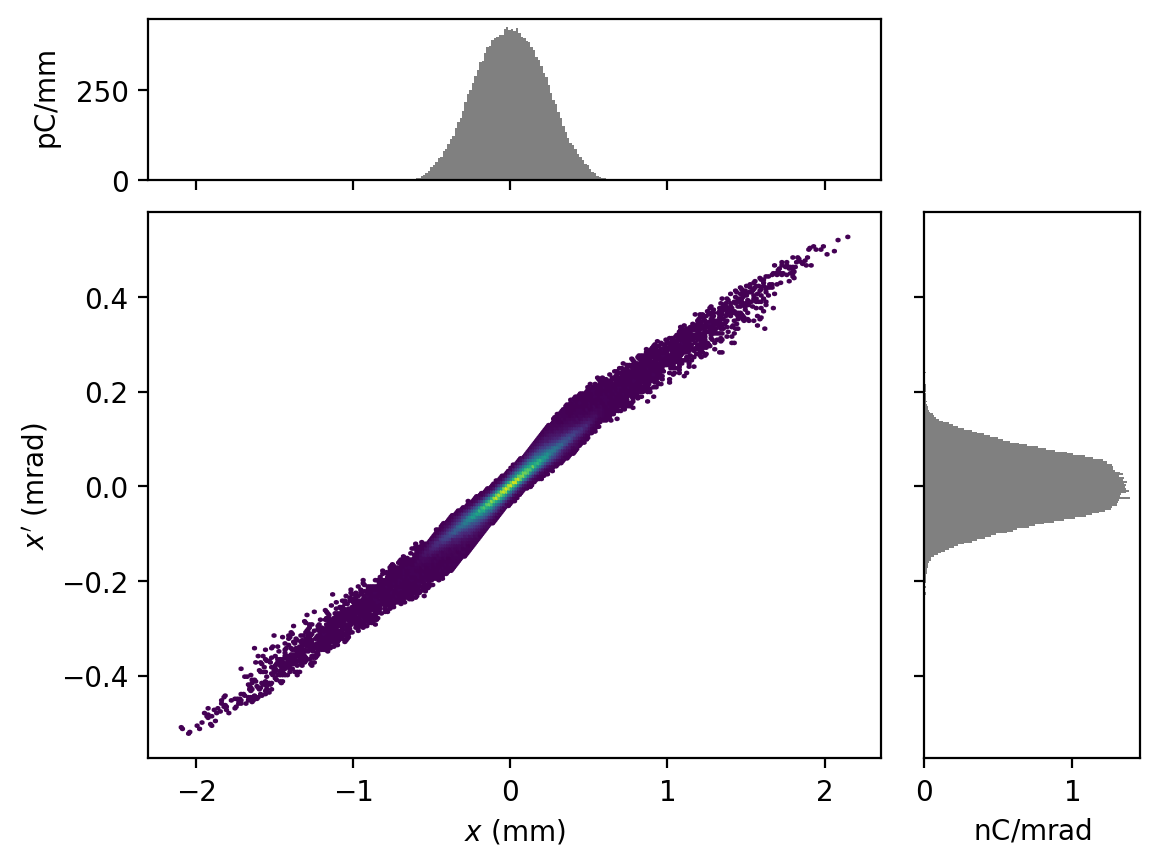

In [23]:
P.plot('x', 'xp')


In [24]:
P.twiss('xy')

{'alpha_x': -4.800000002310883,
 'beta_x': 17.20000000171702,
 'gamma_x': 1.397674419754921,
 'emit_x': 3.3698861333763624e-09,
 'eta_x': -8.119903137781223e-06,
 'etap_x': -1.5727061299569443e-06,
 'norm_emit_x': 4.2115695167519294e-07,
 'alpha_y': -4.800000011596326,
 'beta_y': 17.200000048258733,
 'gamma_y': 1.397674421155508,
 'emit_y': 3.3797998265326207e-09,
 'eta_y': 1.5067735161993908e-05,
 'etap_y': 6.056229864526008e-06,
 'norm_emit_y': 4.223959314579756e-07}

# # Set initial beam 

In [25]:
tao.cmd('set global plot_on = F')
tao.cmd('set global lattice_calc_on = F')
tao.cmd(f'set beam_init position_file = {PFILE}')
tao.cmd(f'set beam_init track_start = {TRACK_START}')
tao.cmd(f'set beam_init track_end = {TRACK_END}')
tao.cmd(f'set beam_init bunch_charge = {P.charge}')
tao.cmd(f'set beam_init n_particle = {len(P)}')
tao.cmd('set global lattice_calc_on = T')
tao.cmd('set global plot_on = T')


#tao.cmd('call $LCLS_LATTICE/bmad/models/cu_hxr/scripts/Activate_CSR.tao')
#tao.cmd('csron')

[]

# Track

In [26]:
# Toggle beam
#tao.cmd('set global track_type = beam;set global track_type = single') 
tao.cmd('set global track_type = beam') # default mode is "single"

['Beam at Element: 237. Time: 1 min',
 'Beam at Element: 379. Time: 2 min',
 'Beam at Element: 505. Time: 3 min',
 'Beam at Element: 617. Time: 4 min',
 'Beam at Element: 747. Time: 5 min',
 'Beam at Element: 870. Time: 6 min',
 'Beam at Element: 973. Time: 7 min',
 'Beam at Element: 1124. Time: 8 min',
 'Beam at Element: 1282. Time: 9 min',
 'Beam at Element: 1444. Time: 10 min']

# Get partices at end

In [27]:
P1 = ParticleGroup(data=tao.bunch_data('ENDCLTH_0'))

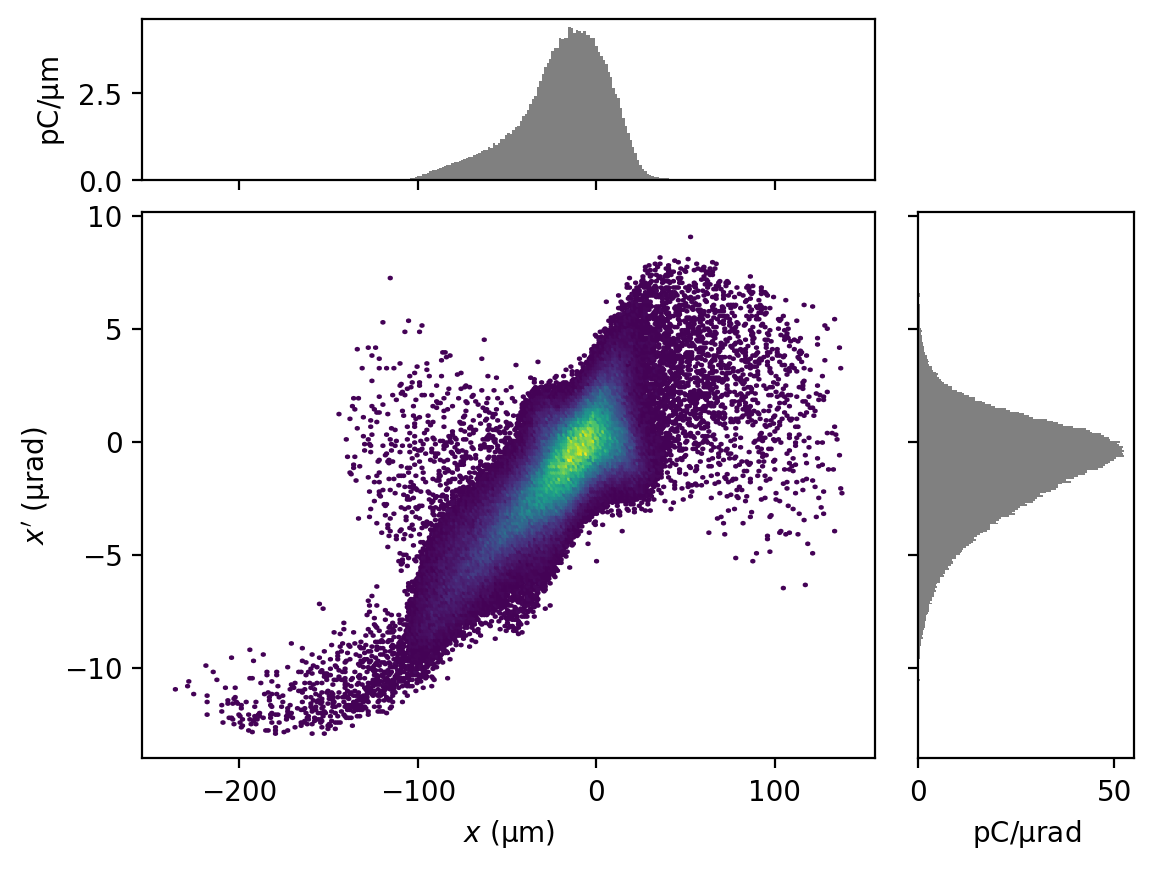

In [28]:
P1.plot('x', 'xp')

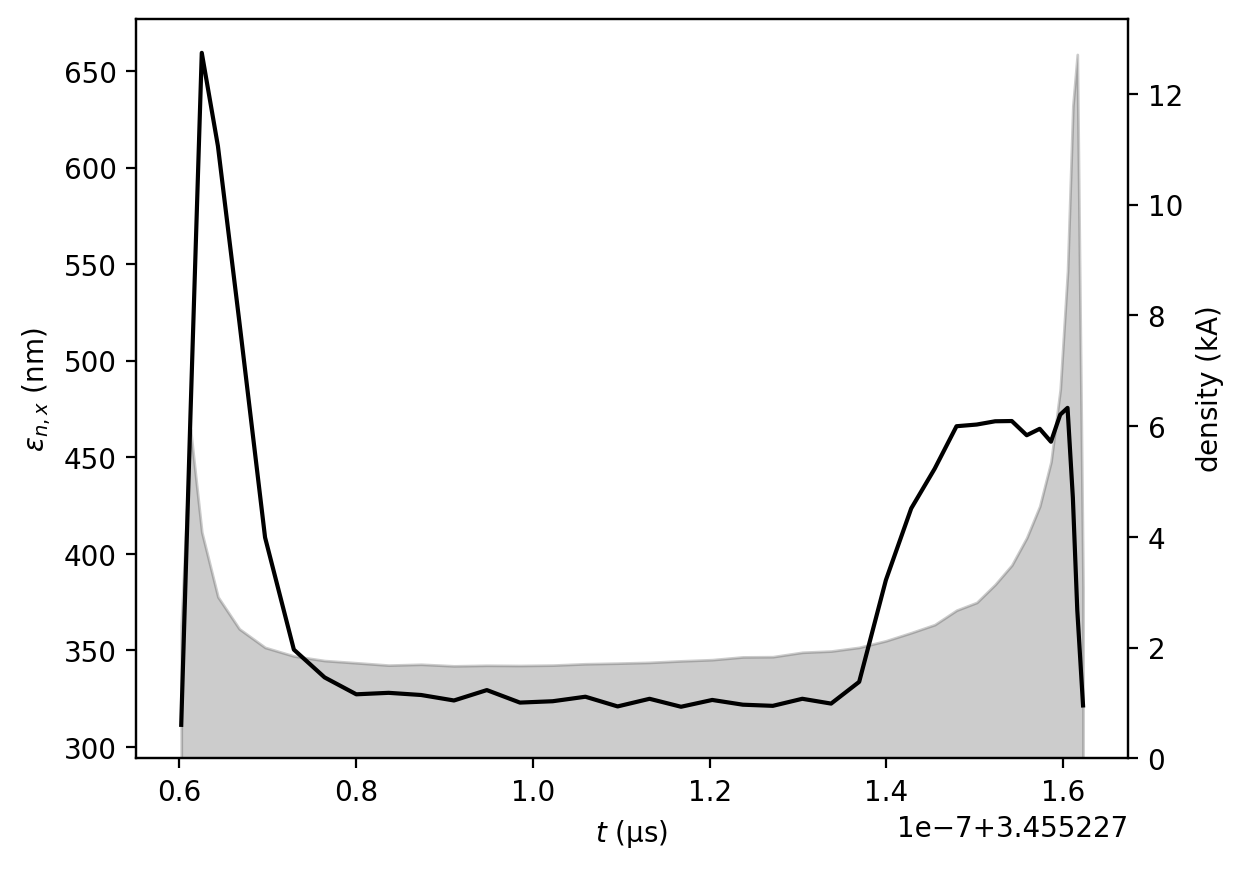

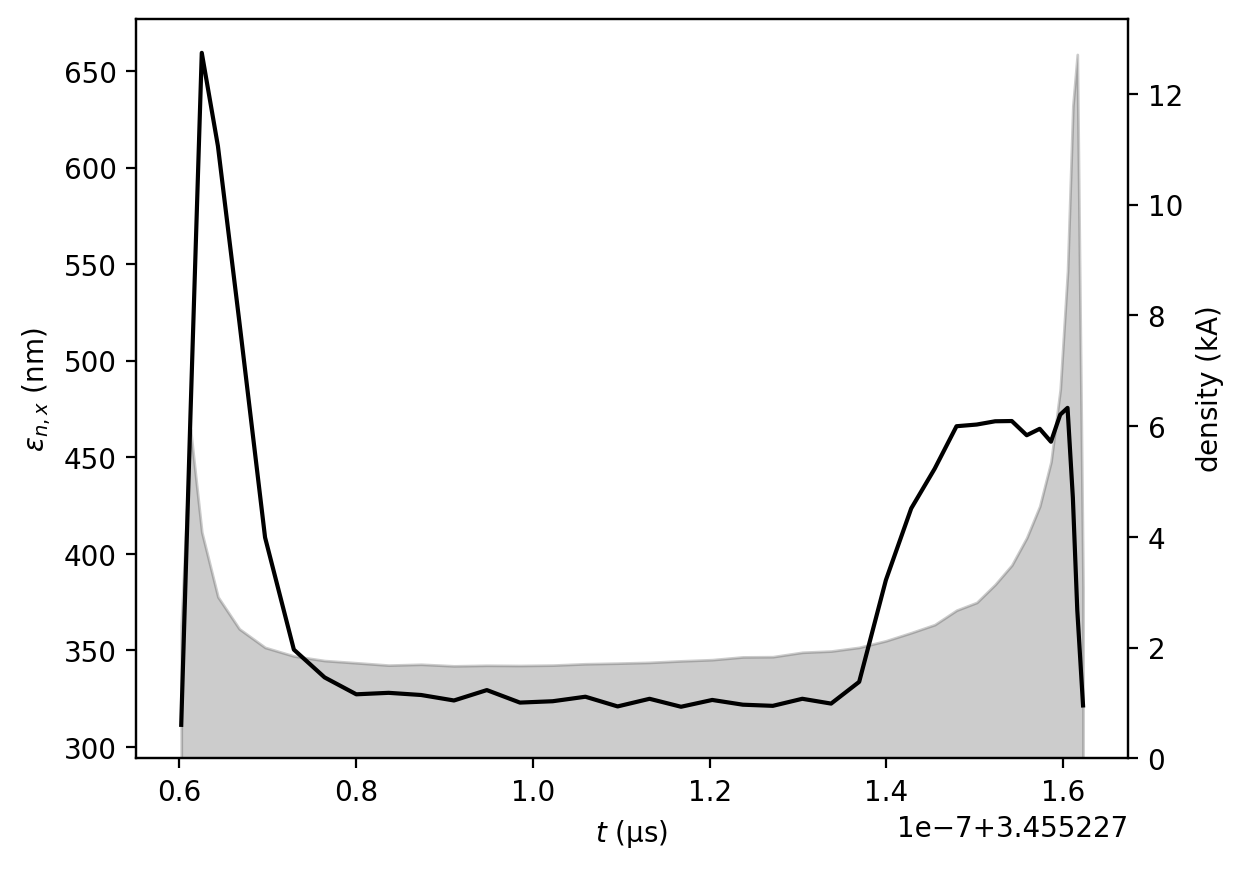

In [29]:
slice_plot(P1, 'norm_emit_x', slice_key='t')

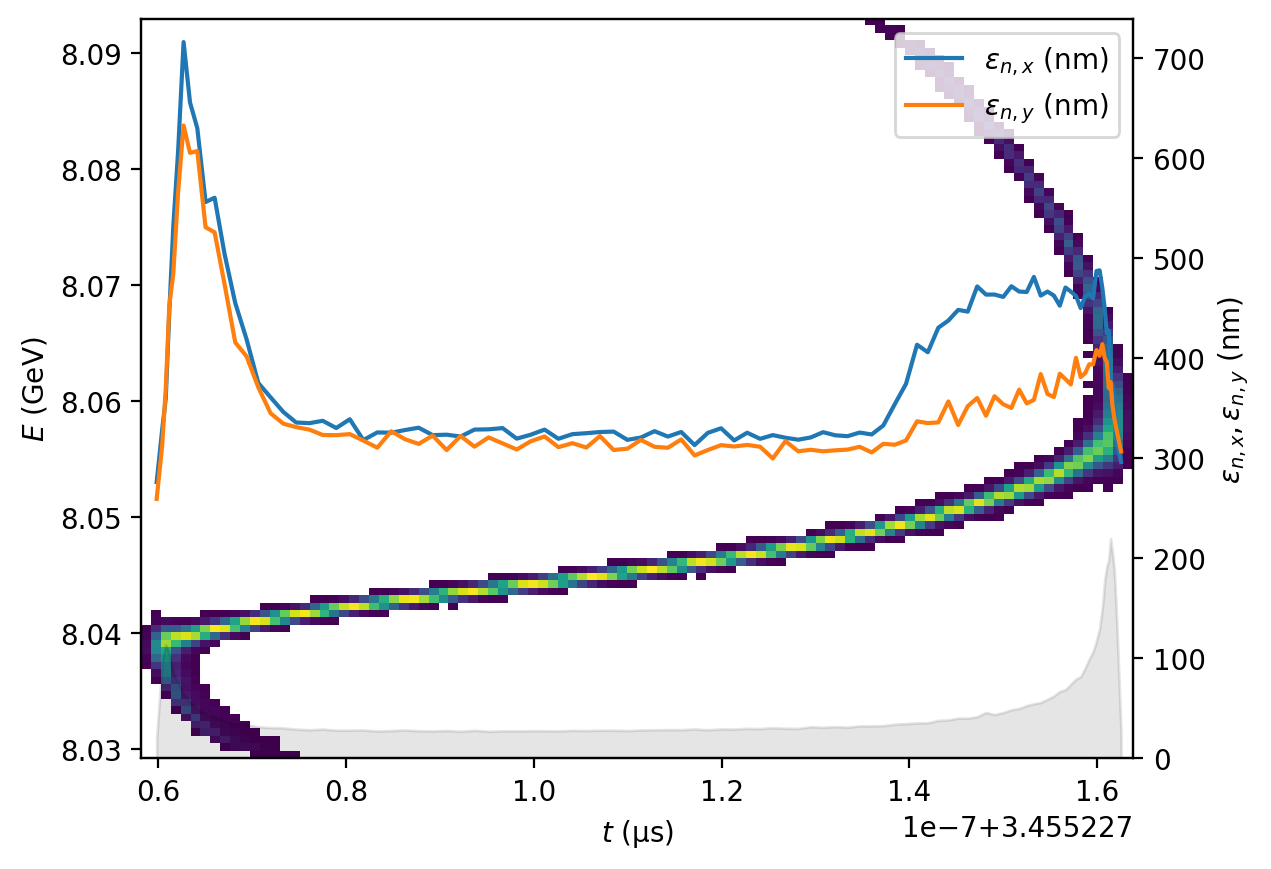

In [30]:
density_and_slice_plot(P1, 't', 'energy', stat_keys = ['norm_emit_x', 'norm_emit_y'], n_slice = 100, bins=100)
#plt.xlim(4.2, 4.3)

## Plot

In [31]:
%%tao
x-a all s
sc

-------------------------
Tao> x-a all s
-------------------------
Tao> sc
-------------------------
Tao> 


# Save the files

In [32]:
PFILE02 = folder_path + '/Tao_output.h5'
P1.write(PFILE02)

# Genesis Simulations

In [33]:
from genesis.version4 import Genesis4
from genesis import tools

### Read in an match the beam

In [34]:
PFILE0 = folder_path + '/Tao_output.h5'
P1 = ParticleGroup(PFILE0)
NSAMPLE = len(P1)
P1 = P1.resample(NSAMPLE)

twiss_match = True
alpha_x0 = -0.7393217413918415 
beta_x0 = 7.910909406464387
alpha_y0 = 1.3870723536888105 
beta_y0 = 16.8811786213468987

# Change to s-coordinates (different times t, constant z)
P1.drift_to_z() # drift to P['mean_z']

#t_ref=0
# Zero out the mean time
#P1.t += t_ref -P1['mean_t']

if twiss_match:
    P1.twiss_match(beta =  beta_x0  , alpha =alpha_x0, plane = 'x', inplace = True)
    P1.twiss_match(beta =  beta_y0  , alpha =alpha_y0, plane = 'y', inplace = True)

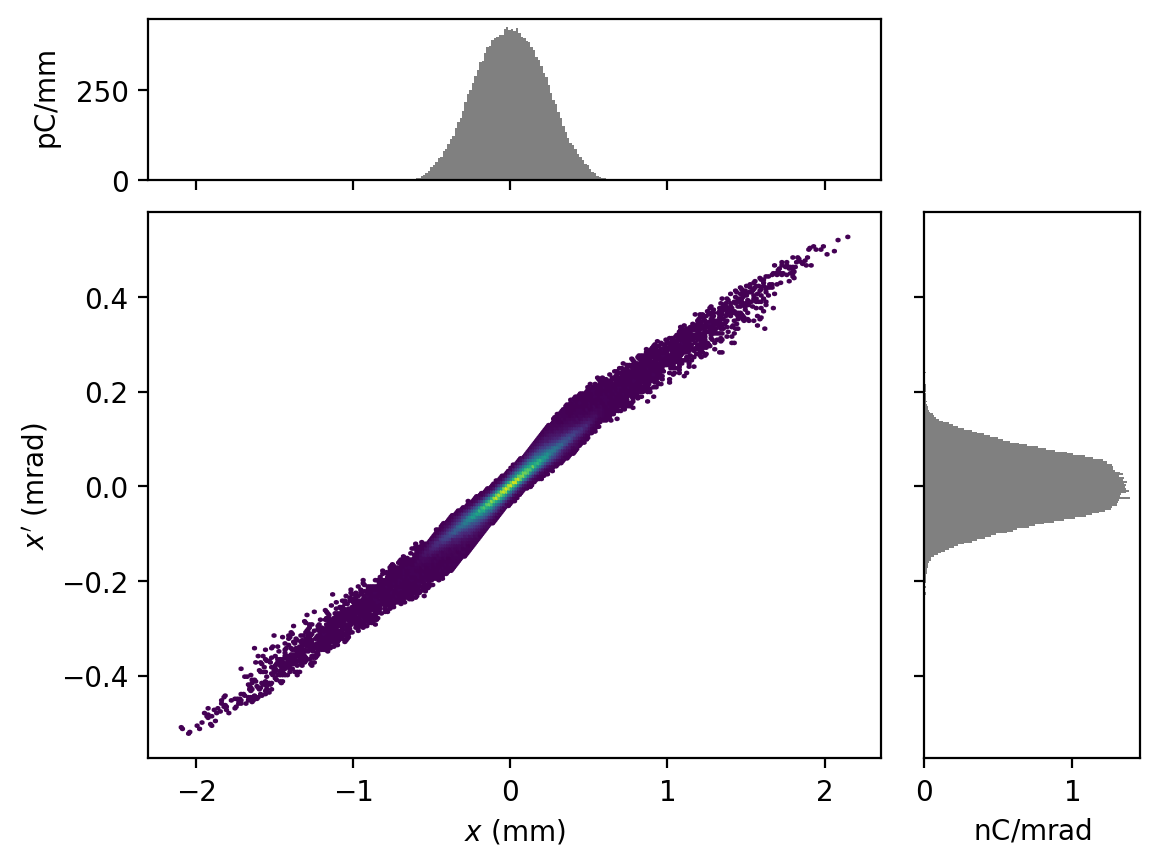

In [35]:
P.plot('x', 'xp') #Lets check we have the right beam

## Set up the simulation using the lcls repo files

In [36]:
# Get the relevant files and directories
run_file_location=os.path.expandvars('$LCLS_LATTICE/genesis/version4/cu_hxr/')
run_file=os.path.expandvars('cu_hxr.in')
workdir=os.path.expandvars('$SCRATCH')

G = Genesis4(run_file_location + run_file, workdir=workdir, verbose = True)

Configured to run in: /sdf/scratch/users/j/jmorgan/tmp3cp20386


In [37]:
nproc=16
G.nproc = nproc
# here we can make changes to the input files for this simulatin run in scratch
gamma=15750.807133238239 
lamda0=2.041420496336648e-10
G.input['main'][0]['gamma0'] = gamma # if we need to change gamma0
G.input['main'][0]['lambda0']= lamda0 # lamda needs to change is gamma undulator strength in lat file au=:1.7017

G.input['main'].append({'type': 'write', 'beam': 'end'})  # this writes out the particles at the ened of the simulation

# Now use the partilce data, this will right the particles in the file format the Genesis expects. 
G.initial_particles = P1

#

In [38]:
# we are ready to run genesis
G.write_input(path=G.path, input_filename=run_file)
runscript = 'salloc --' + partion +' --account '+ account + ' --mem-per-cpu=4g  -n {nproc} mpirun -n {nproc} {command_mpi} {inputfile}'.format(nproc = G.nproc, command_mpi = G.command_mpi, inputfile = G.path + '/' + run_file)
log = []
for path in tools.execute(runscript.split(), cwd=G.path):
    G.vprint(path, end="")
    log.append(path)
G.vprint("Finished.")

Initial particles written to /sdf/scratch/users/j/jmorgan/tmp3cp20386/genesis4_importdistribution.h5
Updated slen = 3.168935690700944e-05
Removed 'beam' from input, will be replaced by 'importdistribution'
Added new importdistribution before the first track
Setting use_mpi = True because nproc = 16


salloc: Pending job allocation 45386840
salloc: job 45386840 queued and waiting for resources
salloc: job 45386840 has been allocated resources
salloc: Granted job allocation 45386840
salloc: Waiting for resource configuration
salloc: Nodes sdfmilan[104-105] are ready for job


---------------------------------------------
GENESIS - Version 4.6.6 has started...
Compile info: Compiled by conda at 2024-01-11 18:02:26 [UTC] from Git Commit ID: 226c27d5b1b045a8195218d2ce5d63aaa10537c7
Starting Time: Tue Apr 30 11:05:04 2024

MPI-Comm Size: 16 nodes

Opened input file /sdf/scratch/users/j/jmorgan/tmp3cp20386/cu_hxr.in
Parsing lattice file hxr.lat ...
Setting up time window of 32.0095 microns with 784 sample points...
Generating input radiation field for HARM = 1 ...
Adding profile with label: beamcurrent
Adding profile with label: beamgamma
Importing distribution file... 
Charge of external distribution: 2.5e-10
Particles in external distribution: 300000
Analysing external distribution... 
*** Non-matching PArticle Transfar: Rank: 1 Deleted: 16694 Forward: 14016 Backward: 3290
*** Non-matching PArticle Transfar: Rank: 2 Deleted: 17317 Forward: 12686 Backward: 5039
*** Non-matching PArticle Transfar: Rank: 3 Deleted: 17558 Forward: 11727 Backward: 6163
*** Non-matc

salloc: Relinquishing job allocation 45386840
salloc: Job allocation 45386840 has been revoked.


Finished.


Loading main output: /sdf/scratch/users/j/jmorgan/tmp3cp20386/LCLS2_HXR_9keV.out.h5


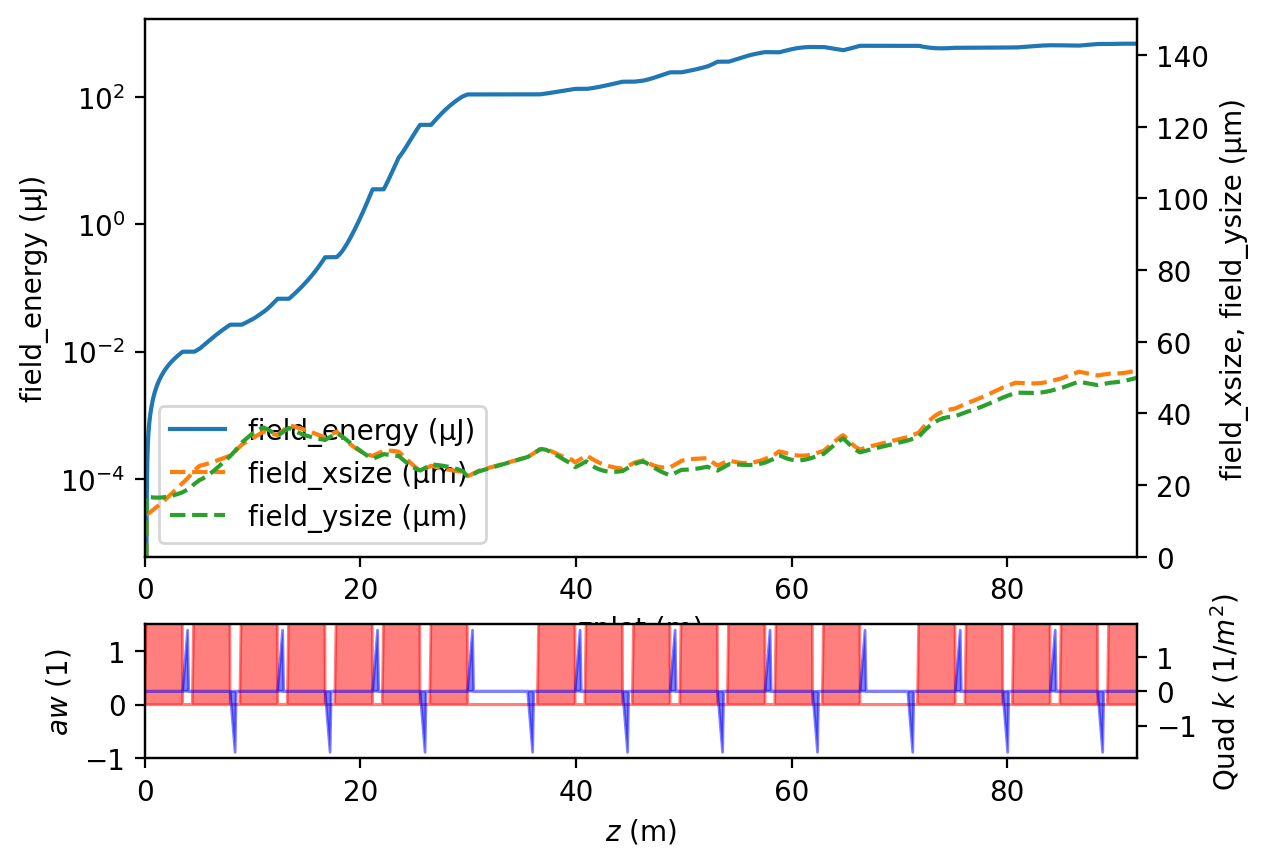

In [39]:
G.log = log
G.load_output()
G.plot('field_energy', yscale='log', y2 = ['field_xsize', 'field_ysize'], ylim2=(0e-6, 150e-6))

Loaded particle data: 'end' as a ParticleGroup with 799744 particles


<ParticleGroup with 799744 particles at 0x7f3f8c6a6c40>

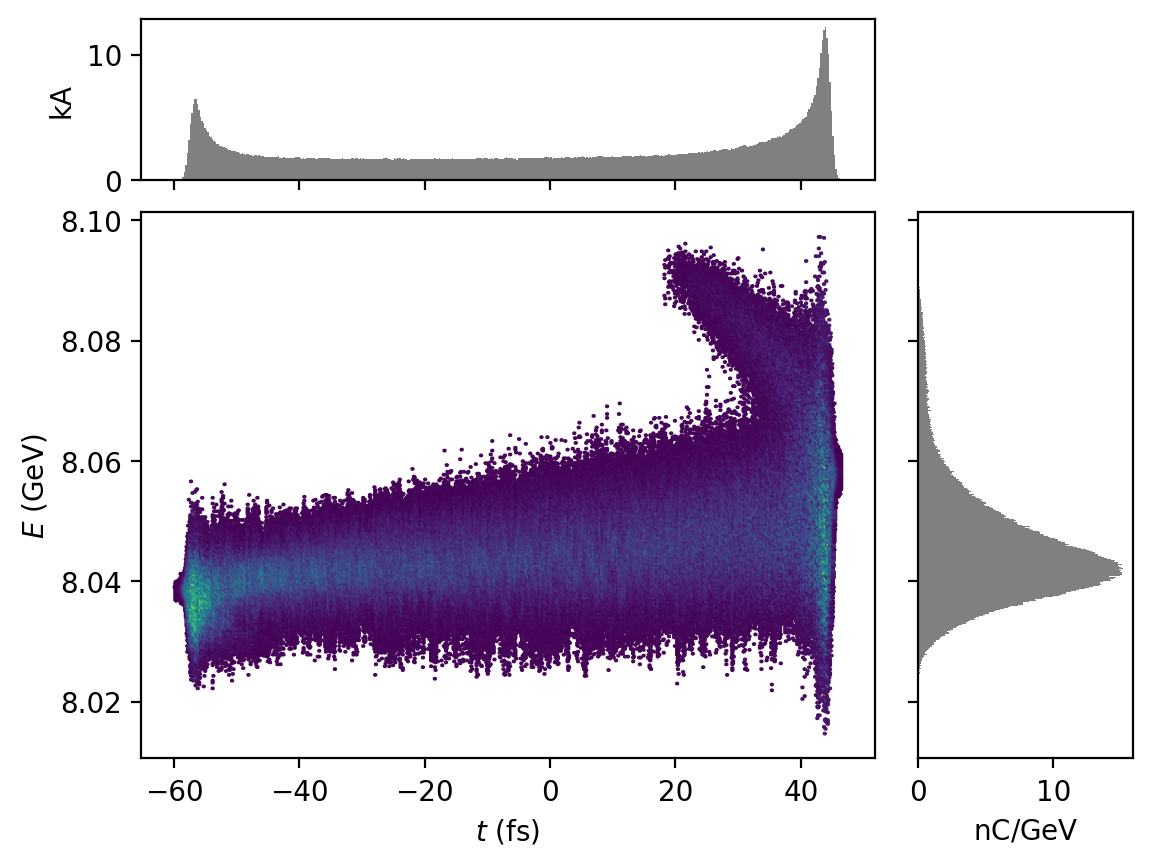

In [40]:
G.load_particles()
P1 = G.particles['end']
P1.drift_to_z()
P1.plot('t', 'energy')
P1